<a href="https://colab.research.google.com/github/Senna126/Op2---Cos3008/blob/main/DashBoard_FEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install fpdf2 gradio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from fpdf import FPDF
import gradio as gr
from math import pi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 10.4 MB/s eta 0:00:00


In [2]:
class RunConfig:
    def __init__(self, frequency="daily", risk_free_ann=0.03, n_trials=100):
        self.frequency = frequency
        self.rf_ann = risk_free_ann
        self.factor = {"daily":252,"weekly":52,"monthly":12}[frequency]
        self.n_trials = n_trials
        self.gates = {
            "Sharpe":1.2, "Sortino":1.5, "Calmar":0.8,
            "Profit Factor":1.3, "DSR":0.0
        }

# Example simulated data (replace with your returns)
np.random.seed(42)
returns_patchtst = pd.Series(np.random.normal(0.001,0.02,252))
returns_autoformer = pd.Series(np.random.normal(0.0007,0.018,252))

strategies = {
    "PatchTST": returns_patchtst,
    "Autoformer": returns_autoformer
}


In [3]:
class MetricsEngine:
    def __init__(self, cfg: RunConfig):
        self.cfg = cfg

    def _annualize(self, mu, sd):
        return mu*self.cfg.factor, sd*np.sqrt(self.cfg.factor)

    def sharpe(self, r):
        mu, sd = r.mean(), r.std(ddof=1)
        if sd==0: return np.nan
        mu_a, sd_a = self._annualize(mu, sd)
        return mu_a/sd_a

    def sortino(self, r):
        downside = r[r<0]
        if len(downside)==0: return np.inf
        mu = r.mean()
        dsd = downside.std(ddof=1)
        mu_a, dsd_a = self._annualize(mu, dsd)
        return mu_a/dsd_a

    def max_dd(self, r):
        eq = (1+r).cumprod()
        peak = eq.cummax()
        dd = (eq/peak)-1
        return abs(dd.min()), eq, dd

    def calmar(self, r):
        mu = r.mean()
        mu_a,_ = self._annualize(mu, r.std())
        mdd,_,_ = self.max_dd(r)
        return np.inf if mdd==0 else mu_a/mdd

    def profit_factor(self, r):
        gains = r[r>0].sum()
        losses = -r[r<0].sum()
        return np.inf if losses==0 else gains/losses

    def psr_dsr(self, r):
        sr = self.sharpe(r)
        n = len(r)
        if n<3 or np.isnan(sr): return {"psr":np.nan,"dsr":np.nan}
        sr_std = np.sqrt((1+(sr**2)/2)/(n-1))
        adj = sr - sr_std*(np.sqrt(2*np.log(self.cfg.n_trials)))
        dsr = adj/sr_std
        psr = 1 - norm.cdf((0-sr)/sr_std)
        return {"psr":psr,"dsr":dsr}

    def evaluate(self, r):
        out = {}
        out["Sharpe"] = self.sharpe(r)
        out["Sortino"] = self.sortino(r)
        out["Calmar"] = self.calmar(r)
        out["Profit Factor"] = self.profit_factor(r)
        mdd, eq, dd = self.max_dd(r)
        out["MaxDD"] = mdd
        over = self.psr_dsr(r)
        out["PSR"], out["DSR"] = over["psr"], over["dsr"]
        return out, eq, dd


In [4]:
class GatesPolicy:
    def __init__(self, cfg: RunConfig):
        self.cfg = cfg

    def evaluate(self, metrics: dict):
        verdicts = {}
        for k,v in self.cfg.gates.items():
            verdicts[k] = metrics.get(k, np.nan) >= v
        return verdicts

def run_dashboard(strategies, cfg: RunConfig):
    engine = MetricsEngine(cfg)
    policy = GatesPolicy(cfg)
    rows = []

    for name,r in strategies.items():
        m,eq,dd = engine.evaluate(r)
        gates = policy.evaluate(m)
        row = {**m, **{f"{k} PASS":v for k,v in gates.items()}}
        rows.append(pd.Series(row, name=name))

        # Equity + Drawdown plots
        fig,ax = plt.subplots(2,1,figsize=(10,6),sharex=True)
        eq.plot(ax=ax[0], title=f"Equity Curve – {name}")
        dd.plot(ax=ax[1], title=f"Drawdown – {name}")
        plt.show()

    df = pd.DataFrame(rows)
    display(df)
    return df


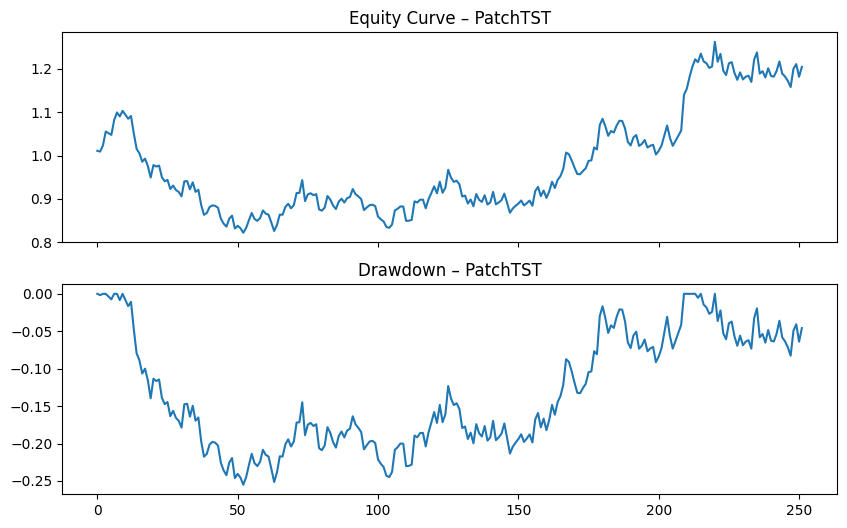

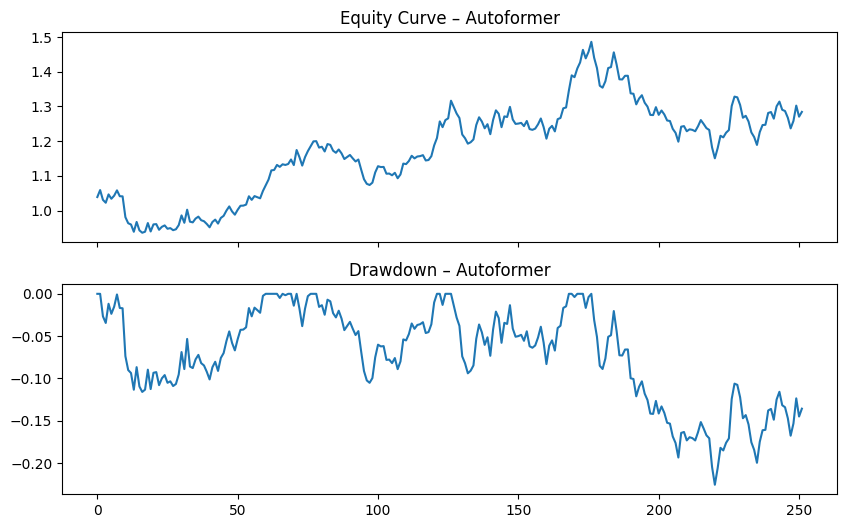

,Sharpe,Sortino,Calmar,Profit Factor,MaxDD,PSR,DSR,Sharpe PASS,Sortino PASS,Calmar PASS,Profit Factor PASS,DSR PASS
PatchTST,0.758838,1.385607,0.913579,1.128335,0.255068,1.0,7.558707,False,False,True,False,True
Autoformer,1.015865,1.797455,1.289034,1.173921,0.225765,1.0,10.036623,False,True,True,False,True


Saved financial_metrics.csv
Saved financial_metrics.pdf


/tmp/ipython-input-721714135.py:10: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  pdf.set_font("Arial", size=12)
/tmp/ipython-input-721714135.py:11: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(200,10,"Financial Evaluation Dashboard Report",ln=True,align="C")
/tmp/ipython-input-721714135.py:13: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(200,10,f"{strat}:",ln=True)
/tmp/ipython-input-721714135.py:15: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(200,10,f"   {k}: {v:.3f}",ln=True)


In [5]:
cfg = RunConfig()
results = run_dashboard(strategies, cfg)

# Export CSV + PDF
results.to_csv("financial_metrics.csv")
print("Saved financial_metrics.csv")

pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)
pdf.cell(200,10,"Financial Evaluation Dashboard Report",ln=True,align="C")
for strat,row in results.iterrows():
    pdf.cell(200,10,f"{strat}:",ln=True)
    for k,v in row.items():
        pdf.cell(200,10,f"   {k}: {v:.3f}",ln=True)
pdf.output("financial_metrics.pdf")
print("Saved financial_metrics.pdf")


In [6]:
def evaluate_file(file):
    df = pd.read_csv(file.name)
    # Assume CSV has columns: Date, Return, Strategy
    results = []
    cfg = RunConfig()
    engine = MetricsEngine(cfg)
    policy = GatesPolicy(cfg)
    out_text = ""

    for strat in df["Strategy"].unique():
        r = df[df["Strategy"]==strat]["Return"].astype(float)
        m,eq,dd = engine.evaluate(r)
        gates = policy.evaluate(m)
        out_text += f"\n{strat}:\n"
        for k,v in m.items():
            out_text += f"  {k}: {v:.3f}\n"
        for g,v in gates.items():
            out_text += f"  {g} PASS: {v}\n"
    return out_text

demo = gr.Interface(
    fn=evaluate_file,
    inputs=gr.File(label="Upload Returns CSV"),
    outputs="text",
    title="Financial Evolution Metric Dashboard"
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6edc7c02baae7c57ae.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
